In [8]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import glob
import cv2
import numpy as np
from data_utils import JeongganboReader
import matplotlib.pyplot as plt

from exp_utils import make_jng_gen_and_list, read_jngb, template_matching, COLOR_DICT, JngMatcher

np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# Load ext files and paths

## Daegeum
* YeoMinRock score (p17~36)
* pitch names
* notations

In [10]:
%%capture
reader = JeongganboReader()

ymr_infos = {
  "name": 'daegeum',
  "start": 17, # page 17 ~ 36
  "num_page": 20
}

ymr = read_jngb(reader, ymr_infos)
jng_gen, jng_list = make_jng_gen_and_list(reader, ymr)

pattern_path_base = 'test/daegeum/'
pattern_path_sub = ['notations/', 'pitches/']
pattern_ext = '.png'

pattern_paths = { 
  subpath[:-1]: {
    path.replace(f'{pattern_path_base}{subpath}', '').replace(pattern_ext, ''): path \
    for path in glob.glob(f'{pattern_path_base}{subpath}*{pattern_ext}')
  } for subpath in pattern_path_sub 
}

print([ name for name in pattern_paths['notations'].keys() ])
print([ name for name in pattern_paths['pitches'].keys() ])

In [11]:
target_jng_list = jng_list

## Jeonggan previewer

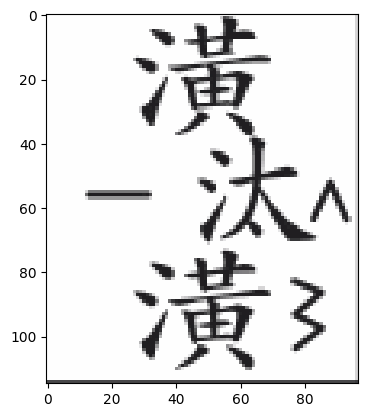

In [12]:
img_preview, _ = target_jng_list[289]
plt.imshow(img_preview)

# bounding box filtering

**CONSTANTS**

* 0: lim, hwang_u
* 4: nam, lim
* 43: joong, tae
* 161: nam, lim, nam
* 286: lim, nam, lim
* 289: hwang, tae, hwang

In [21]:
THRESHOLD = 0.42
MATCH_MODE = cv2.TM_CCOEFF_NORMED
PTRN_SIZE = 42

JNG_INDICES = [0, 4, 43, 161, 286, 289]

PTRN_TEST_ORDER = ['hwang_uu', 'hwang_u', 'hwang', 'joong_u', 'joong', 'lim_u', 'lim_d', 'lim', 'mu_d', 'mu_u', 'mu', 'nam_u', 'nam_d', 'nam', 'tae_u', 'tae']

PNAME_SURFIXS = ['uu, u, d, dd']

PTRN_IMG_DICT = { name: cv2.imread(pattern_paths['pitches'][name]) for name in PTRN_TEST_ORDER }

jng_matcher = JngMatcher(PTRN_SIZE, THRESHOLD, MATCH_MODE)


## confidence filtering in single jeonggan

### JngMatcher: template matching class
* overlap logic fixed

total_merged_bbox:  1


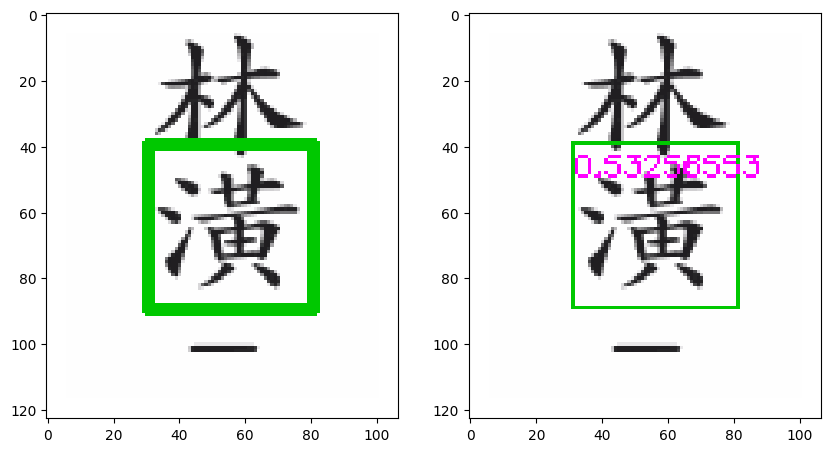

In [22]:
target_jng_idx = 0 # 161
target_pname = 'hwang_u'
local_threshold = 0.5
local_ptrn_size = 50 

jng_img = jng_matcher.remove_border_add_padding(target_jng_list[target_jng_idx][0])
ptrn_img = PTRN_IMG_DICT[target_pname]

xCords, yCords, match_result = jng_matcher.match(jng_img, ptrn_img, ptrn_size=local_ptrn_size, threshold=local_threshold)

bboxs_w_confi = [(x, y, match_result[y][x]) for x, y in zip(xCords, yCords)]

bboxs_merged_w_confi = jng_matcher.merge_bboxs(bboxs_w_confi, ptrn_size=local_ptrn_size)

jng_img_bbox_raw = jng_img.copy()

for box in bboxs_w_confi:
  x, y, _ = box
  cv2.rectangle(jng_img_bbox_raw, (x, y), (x + local_ptrn_size, y+ local_ptrn_size), (0, 200, 0), 1)

jng_img_bbox_merged = jng_img.copy()

for box in bboxs_merged_w_confi:
  tl_x, tl_y, br_x, br_y, confi = box
  cv2.rectangle(jng_img_bbox_merged, (tl_x, tl_y), (br_x, br_y), (0, 200, 0), 1)
  cv2.putText(jng_img_bbox_merged, str(confi), (tl_x, tl_y+10), cv2.FONT_ITALIC, 0.3, (255, 0, 255), 1)

print('total_merged_bbox: ', len(bboxs_merged_w_confi))

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(jng_img_bbox_raw)

plt.subplot(1, 2, 2)
plt.imshow(jng_img_bbox_merged)

### bbox grouping on same character

total bbox 5
{'hwang_uu': [(28, 40, 78, 90, 0.50523466)], 'hwang_u': [(31, 39, 81, 89, 0.53256553)], 'joong_u': [(30, 43, 80, 93, 0.50998986)], 'lim_u': [(27, 0, 77, 50, 0.5612801)], 'lim': [(30, 1, 80, 51, 0.53465796)]}
{'hwang_uu': [(28, 40, 78, 90, 0.50523466)], 'hwang_u': [(31, 39, 81, 89, 0.53256553)], 'joong_u': [(30, 43, 80, 93, 0.50998986)], 'lim_u': [(27, 0, 77, 50, 0.5612801)], 'lim': [(30, 1, 80, 51, 0.53465796)]}


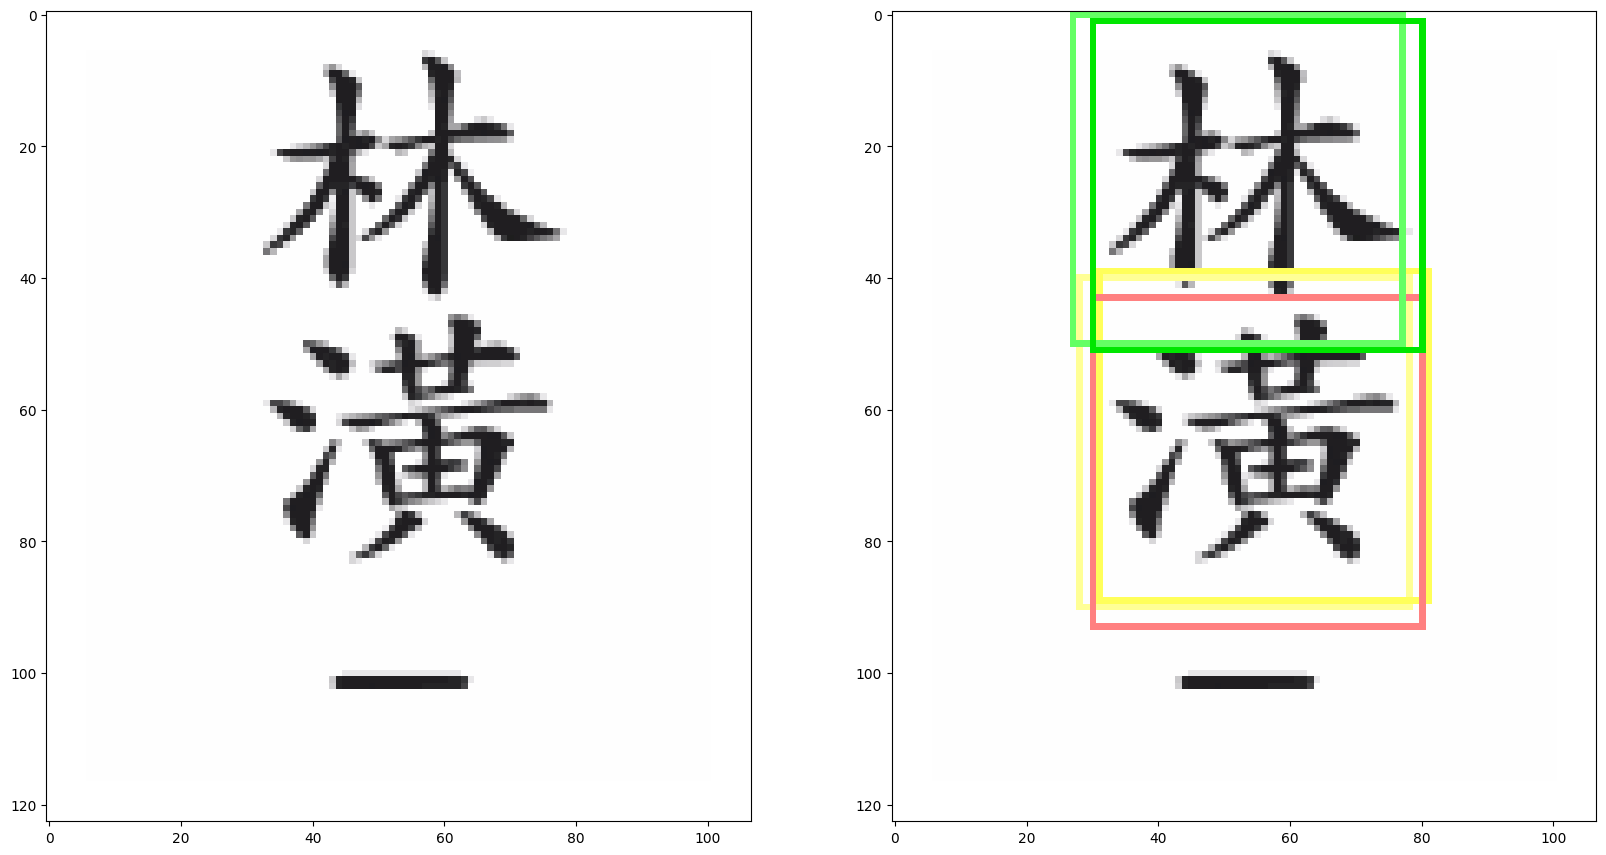

In [23]:
target_jng_idx = 0 # 161
local_threshold = 0.5
local_ptrn_size = 50 

jng_img = jng_matcher.remove_border_add_padding(target_jng_list[target_jng_idx][0])

jng_bbox_dict = {}
jng_bbox_list = []
bbox_total = 0

for ptrn_key, ptrn_img in PTRN_IMG_DICT.items():
  xCords, yCords, match_result = jng_matcher.match(jng_img, ptrn_img, ptrn_size=local_ptrn_size, threshold=local_threshold)
  bboxs_w_confi = [(x, y, match_result[y][x]) for x, y in zip(xCords, yCords)]
  bboxs_merged_w_confi = jng_matcher.merge_bboxs(bboxs_w_confi, ptrn_size=local_ptrn_size)
  
  bbox_total += len(bboxs_merged_w_confi) # for debugging
  
  if(len(bboxs_merged_w_confi) > 0):
    jng_bbox_dict[ptrn_key] = bboxs_merged_w_confi
    jng_bbox_list += [bbox + (ptrn_key,) for bbox in bboxs_merged_w_confi]

print('total bbox', bbox_total)

print(jng_bbox_dict)
# print([(key, [box[4] for box in ls]) for key, ls in jng_bbox_dict.items()])
print(jng_bbox_dict)

jng_img_bbox_merged = jng_img.copy()

for pitch_name, bboxs in jng_bbox_dict.items():
  color = COLOR_DICT[pitch_name]
  
  for box in bboxs:
    tl_x, tl_y, br_x, br_y, confi = box
    cv2.rectangle(jng_img_bbox_merged, (tl_x, tl_y), (br_x, br_y), color, 1)

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(jng_img)

plt.subplot(1, 2, 2)
plt.imshow(jng_img_bbox_merged)

[(27, 0, 77, 50, 0.5612801, 'lim_u'), (30, 1, 80, 51, 0.53465796, 'lim'), (31, 39, 81, 89, 0.53256553, 'hwang_u'), (28, 40, 78, 90, 0.50523466, 'hwang_uu'), (30, 43, 80, 93, 0.50998986, 'joong_u')]
[[(30, 1, 80, 51, 0.53465796, 'lim'), (27, 0, 77, 50, 0.5612801, 'lim_u')], [(28, 40, 78, 90, 0.50523466, 'hwang_uu'), (30, 43, 80, 93, 0.50998986, 'joong_u'), (31, 39, 81, 89, 0.53256553, 'hwang_u')]]


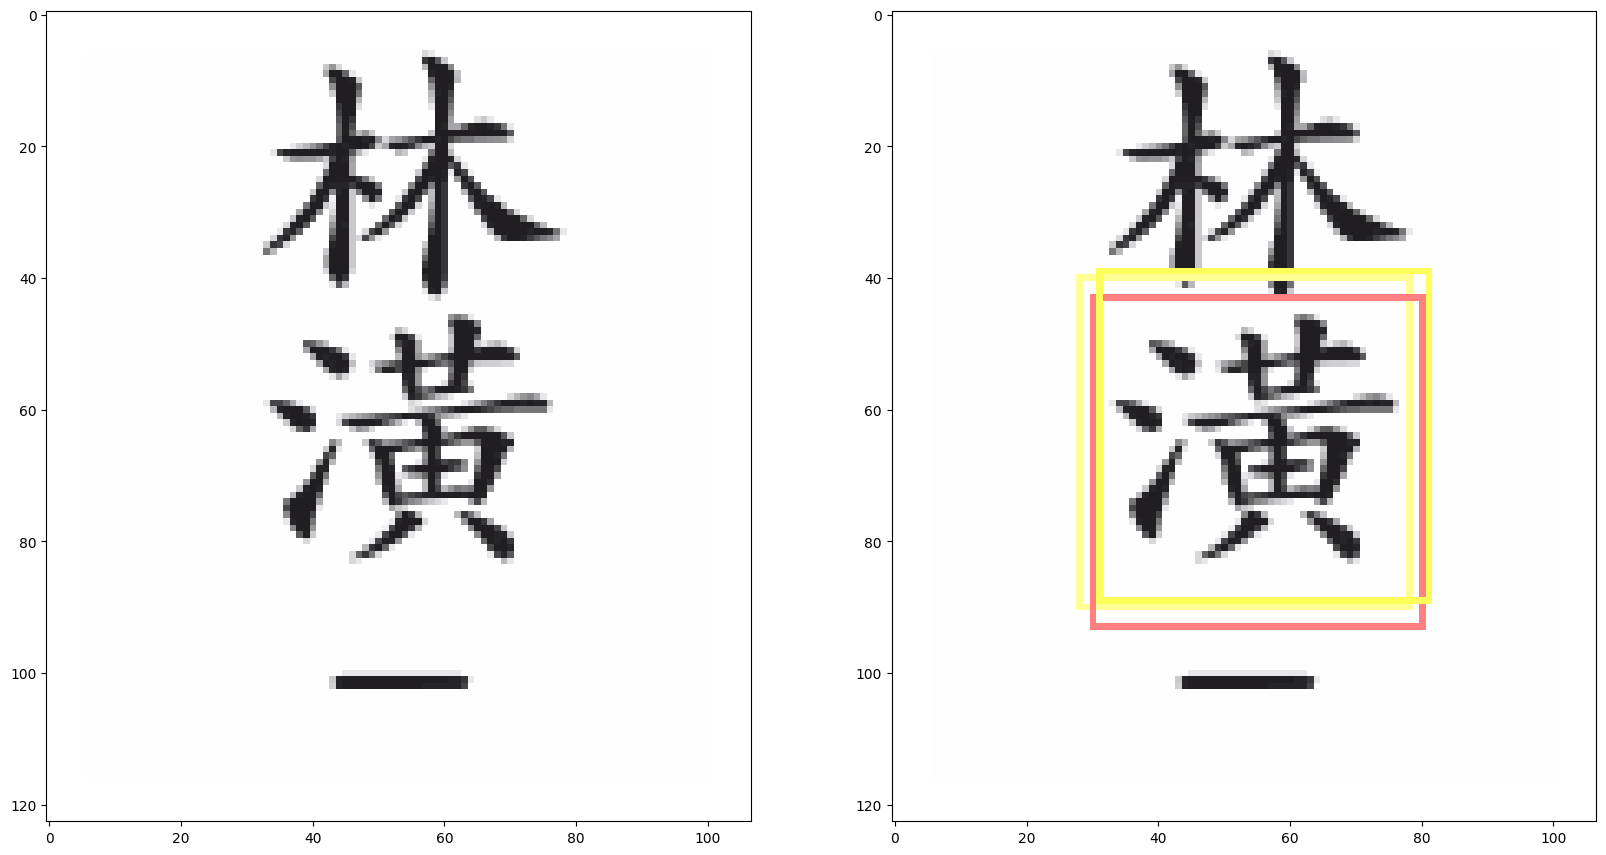

In [30]:
self = jng_matcher

jng_bboxs = sorted(jng_bbox_list, key=lambda b: b[1])

bbox_groups = []
index = 0

print(jng_bboxs)

while True:
  if index > len(jng_bboxs) - 1:
    break
  
  curr = jng_bboxs[index]

  # overlapping box indexs
  overlaps = self.get_overlaps(jng_bboxs, curr, index, min_ratio=0.6)

  if len(overlaps) > 0:
    overlaps_box = [ tup[0] for tup in overlaps ]
    overlaps_box.append(curr)
    
    bbox_groups.append( overlaps_box )
    
    # remove overlaps
    overlaps_idx = [ tup[1] for tup in overlaps ]
    overlaps_idx.sort(reverse=True)
    for overlap_idx in overlaps_idx:
      assert overlap_idx < len(jng_bboxs), f'index out of range: {overlap_idx} / {len(jng_bboxs) - 1}' 
      del jng_bboxs[overlap_idx]
      
  else:
    bbox_groups.append( [curr] )

  index += 1
  
print(bbox_groups)

group_idx = 1

jng_img_bbox_grouped = jng_img.copy()

for idx, box in enumerate(bbox_groups[group_idx]):
  tl_x, tl_y, br_x, br_y, confi, pname  = box
  color = COLOR_DICT[pname]
  
  cv2.rectangle(jng_img_bbox_grouped, (tl_x, tl_y), (br_x, br_y), color, 1)

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(jng_img)

plt.subplot(1, 2, 2)
plt.imshow(jng_img_bbox_grouped)

[(27, 0, 77, 50, 0.5612801, 'lim_u'), (31, 39, 81, 89, 0.53256553, 'hwang_u')]

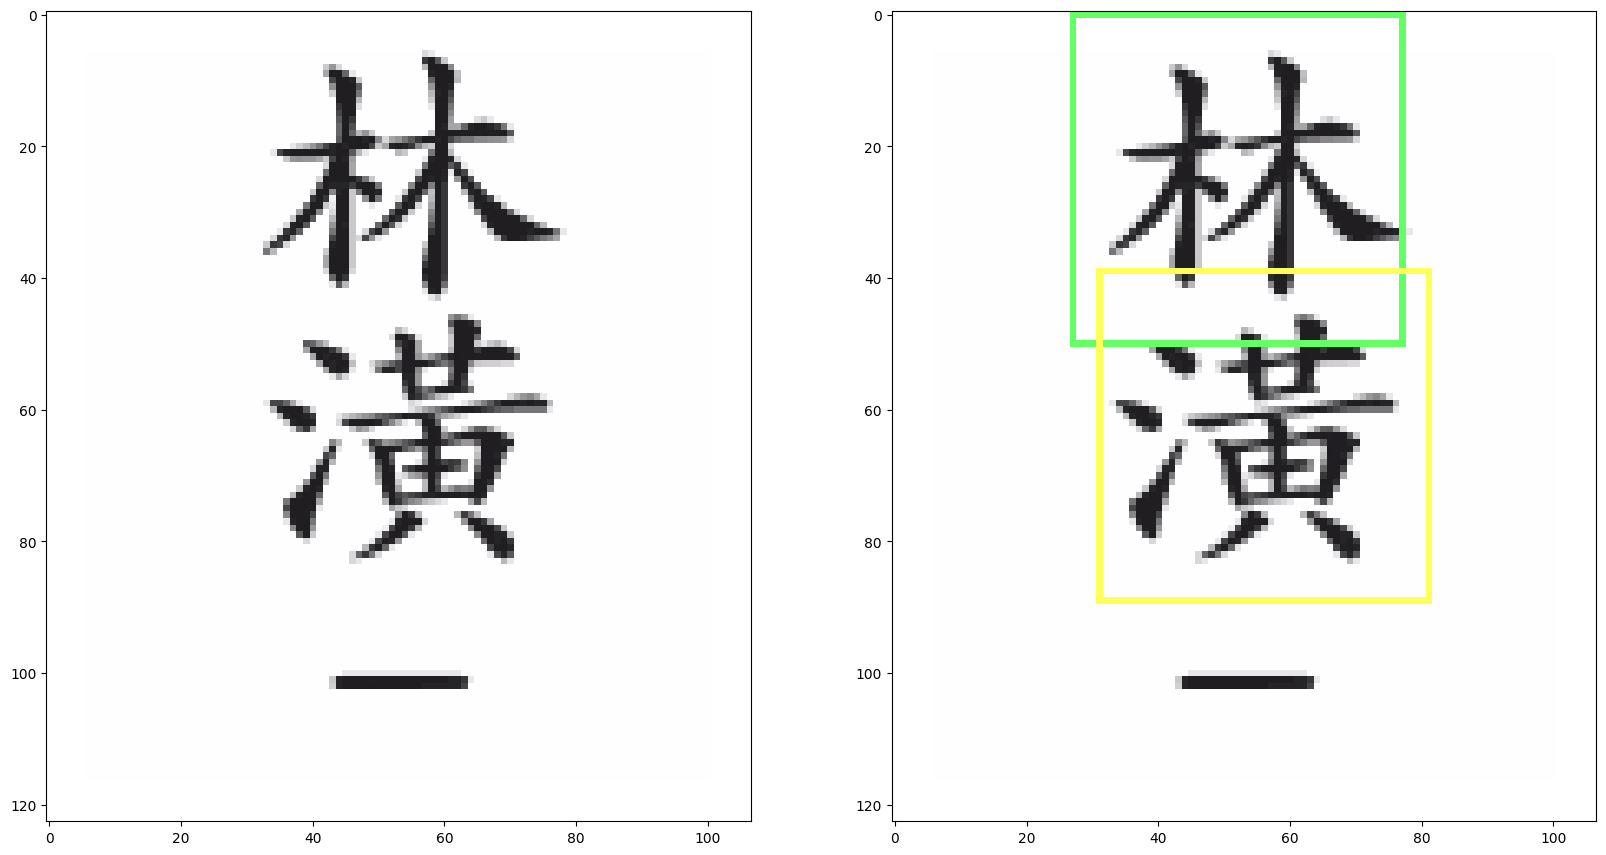

In [31]:
bboxs_filtered =[]

for group in bbox_groups:
  bboxs_filtered.append(max(group, key=lambda b: b[4]))

jng_img_bbox_filtered = jng_img.copy()

for idx, box in enumerate(bboxs_filtered):
  tl_x, tl_y, br_x, br_y, confi, pname  = box
  color = COLOR_DICT[pname]
  
  cv2.rectangle(jng_img_bbox_filtered, (tl_x, tl_y), (br_x, br_y), color, 1)

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(jng_img)

plt.subplot(1, 2, 2)
plt.imshow(jng_img_bbox_filtered)

bboxs_filtered

## confidence filter experiment code 
### multiple pitch names in multiple Jeonggans

* result index 0 ~ 119 
    * **error rate: 14%**
    * total char: 291
    * wrong oct: 25
    * wrong pitch: 11
    * not recoged: 6

0 th jng has  ['lim_u', 'hwang_u']
total bbox:  2


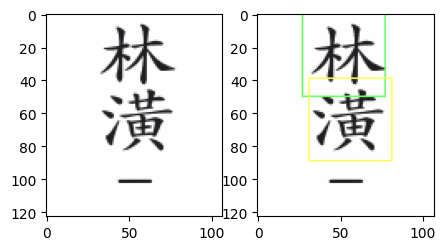

1 th jng has  []
total bbox:  0


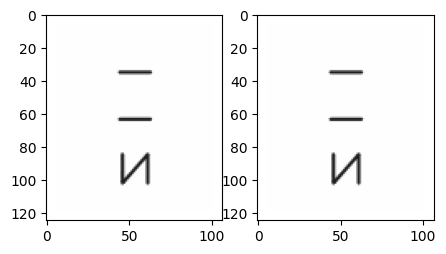

2 th jng has  ['lim_u']
total bbox:  1


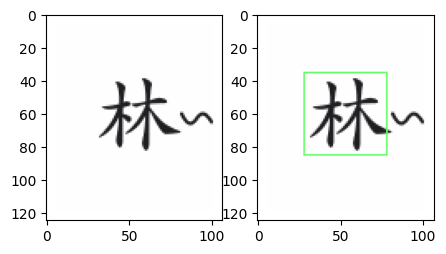

3 th jng has  []
total bbox:  0


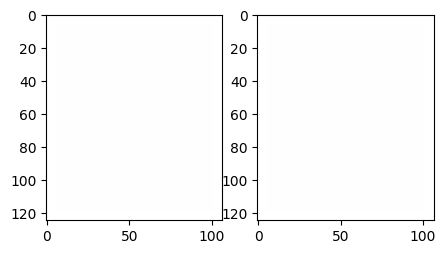

4 th jng has  ['nam', 'lim']
total bbox:  2


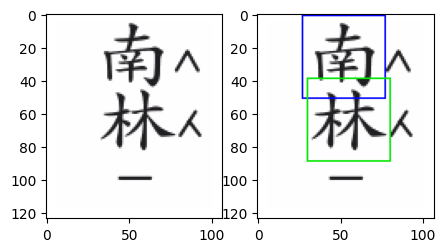

5 th jng has  ['nam']
total bbox:  1


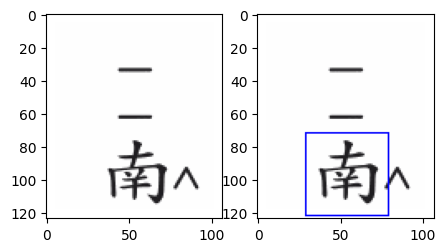

6 th jng has  ['hwang']
total bbox:  1


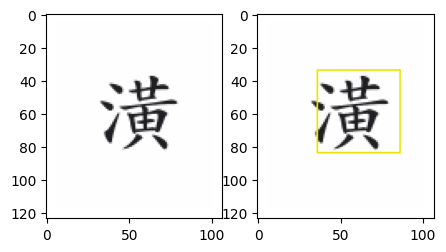

7 th jng has  []
total bbox:  0


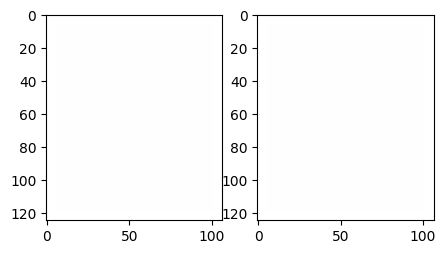

8 th jng has  []
total bbox:  0


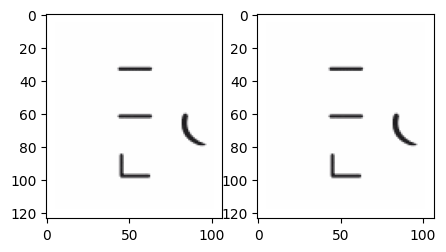

9 th jng has  []
total bbox:  0


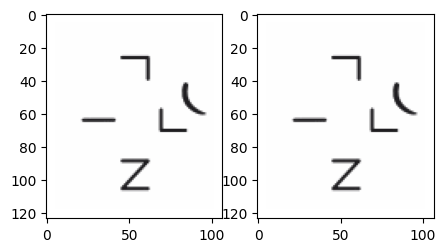

10 th jng has  ['hwang_u', 'joong_u']
total bbox:  2


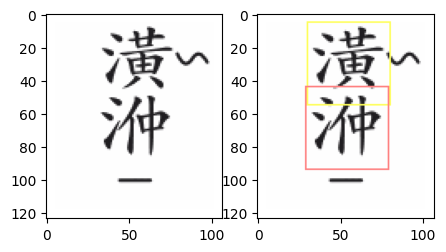

11 th jng has  []
total bbox:  0


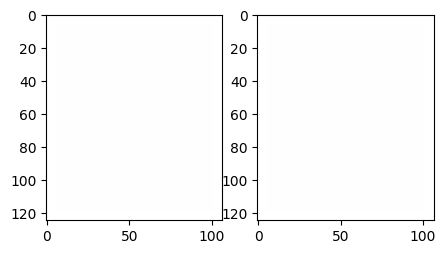

12 th jng has  []
total bbox:  0


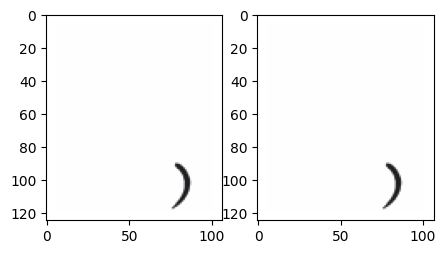

13 th jng has  ['nam_u', 'tae_u']
total bbox:  2


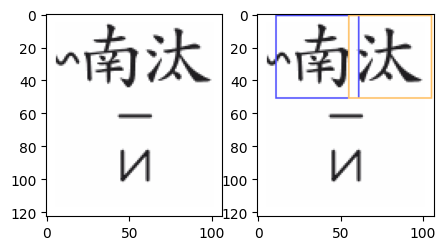

14 th jng has  ['lim_u', 'lim_u']
total bbox:  2


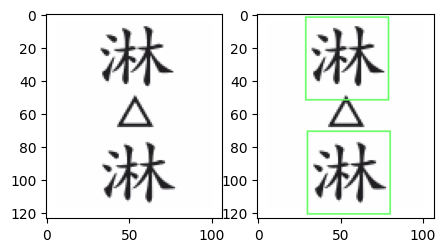

15 th jng has  []
total bbox:  0


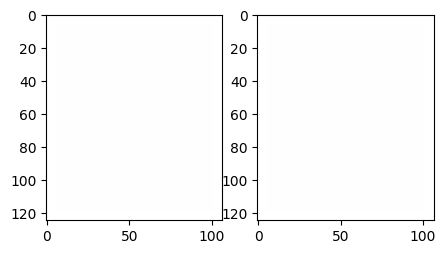

16 th jng has  []
total bbox:  0


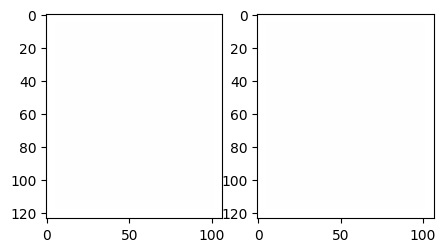

17 th jng has  []
total bbox:  0


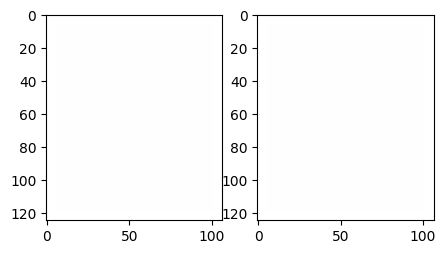

18 th jng has  []
total bbox:  0


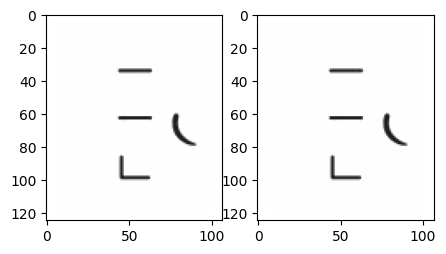

19 th jng has  []
total bbox:  0


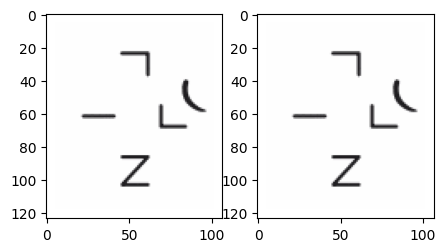

20 th jng has  ['lim_u']
total bbox:  1


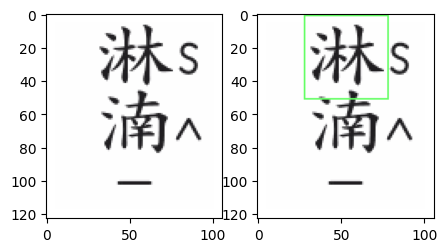

21 th jng has  ['lim']
total bbox:  1


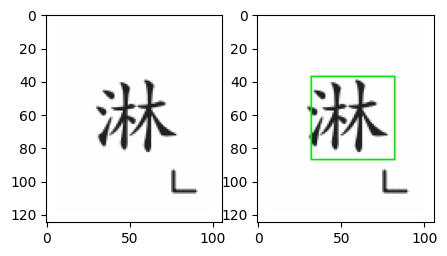

22 th jng has  ['joong_u']
total bbox:  1


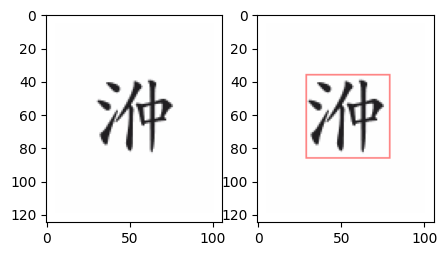

23 th jng has  []
total bbox:  0


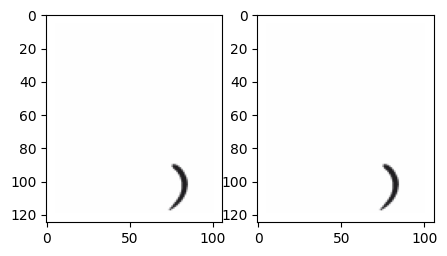

24 th jng has  ['tae_u', 'joong_u', 'lim_u']
total bbox:  3


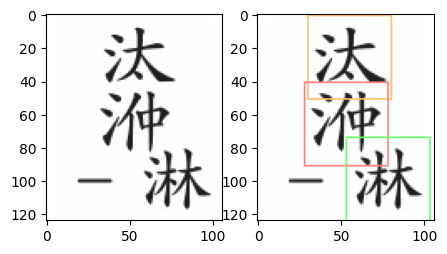

25 th jng has  ['joong_u', 'lim_u']
total bbox:  2


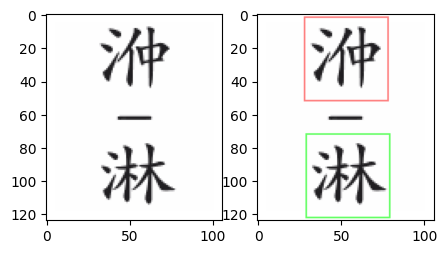

26 th jng has  ['tae_u']
total bbox:  1


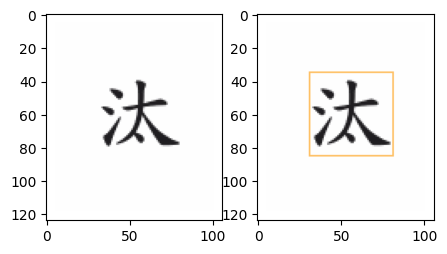

27 th jng has  ['lim', 'joong_u']
total bbox:  2


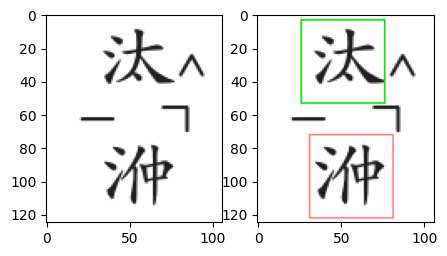

28 th jng has  ['hwang_u', 'lim']
total bbox:  2


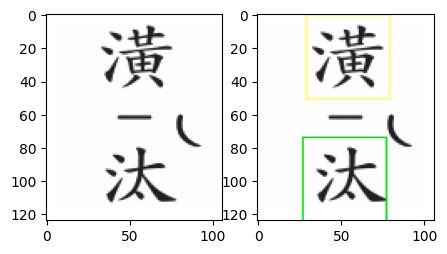

29 th jng has  ['hwang_u', 'nam']
total bbox:  2


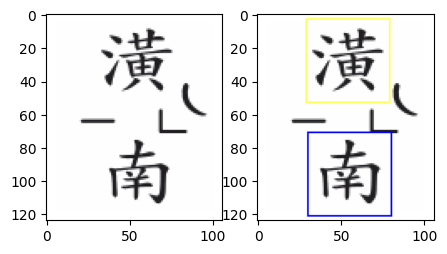

30 th jng has  ['tae_u']
total bbox:  1


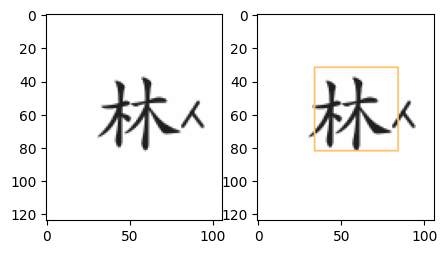

31 th jng has  []
total bbox:  0


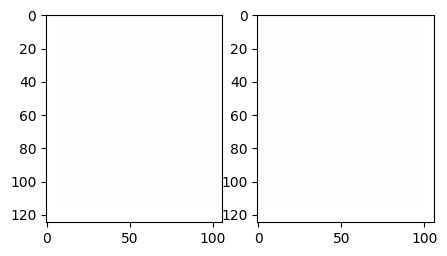

32 th jng has  ['nam', 'lim']
total bbox:  2


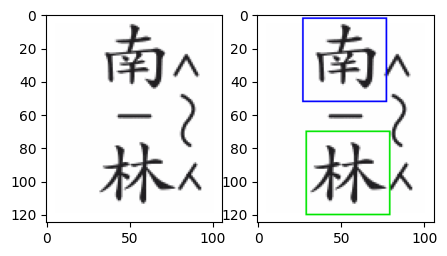

33 th jng has  ['hwang']
total bbox:  1


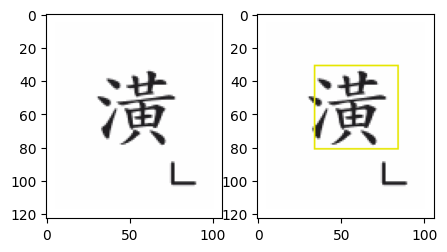

34 th jng has  ['mu']
total bbox:  1


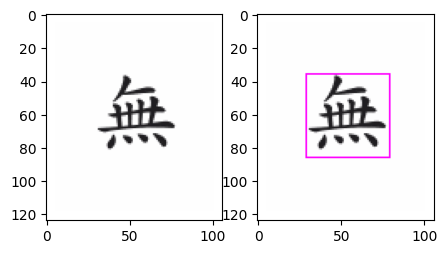

35 th jng has  ['hwang_u']
total bbox:  1


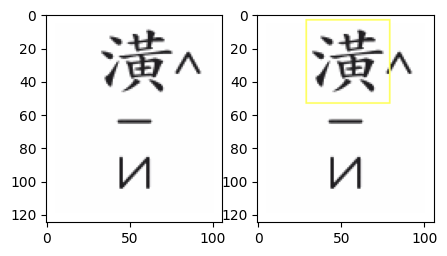

36 th jng has  ['lim_u']
total bbox:  1


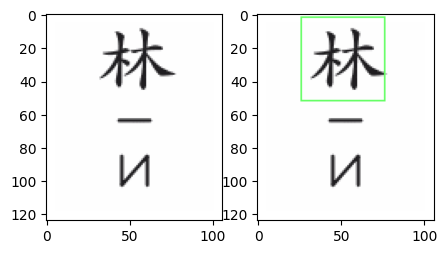

37 th jng has  ['hwang_uu']
total bbox:  1


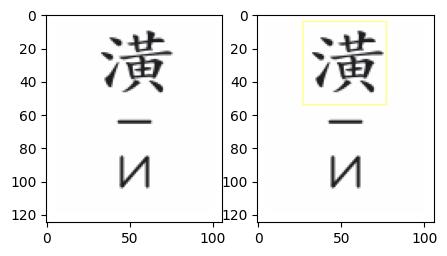

38 th jng has  ['lim_u']
total bbox:  1


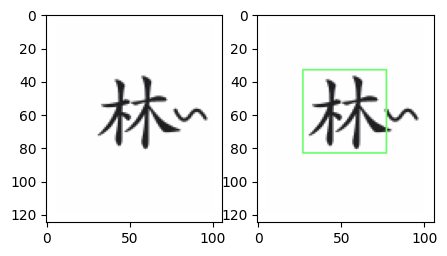

39 th jng has  []
total bbox:  0


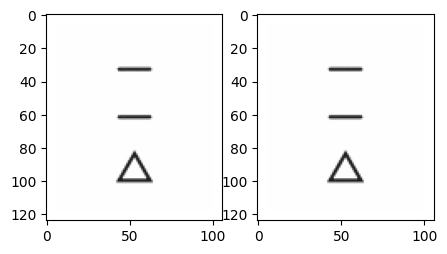

40 th jng has  ['lim_u', 'hwang_u']
total bbox:  2


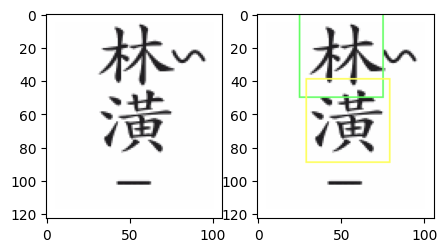

41 th jng has  []
total bbox:  0


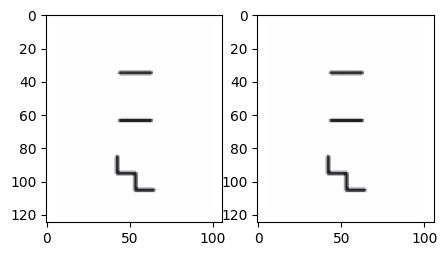

42 th jng has  ['joong', 'lim_u']
total bbox:  2


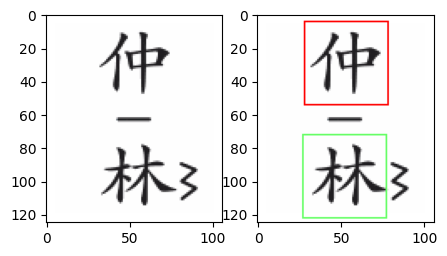

43 th jng has  ['tae', 'joong', 'joong']
total bbox:  3


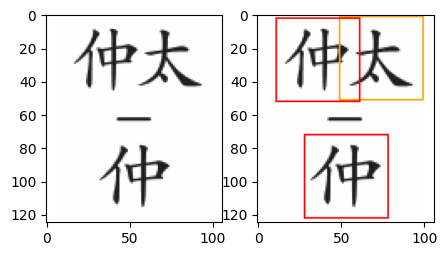

44 th jng has  ['nam', 'lim']
total bbox:  2


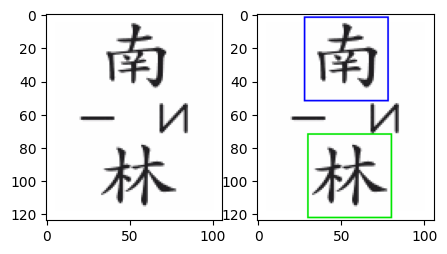

45 th jng has  ['hwang_u']
total bbox:  1


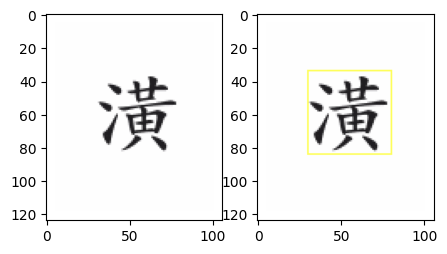

46 th jng has  ['nam_d', 'lim_u']
total bbox:  2


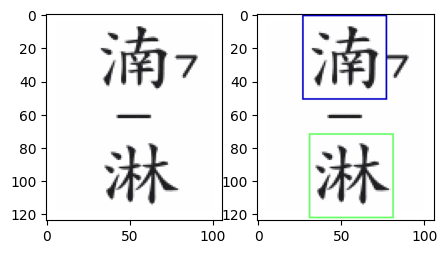

47 th jng has  ['joong']
total bbox:  1


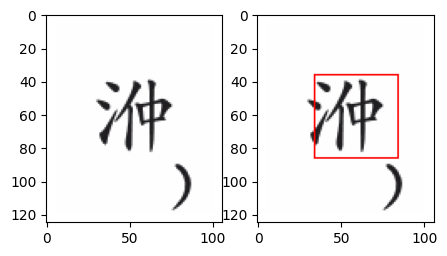

48 th jng has  ['lim', 'tae_u']
total bbox:  2


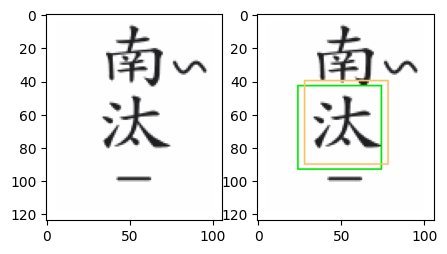

49 th jng has  ['joong_u', 'nam']
total bbox:  2


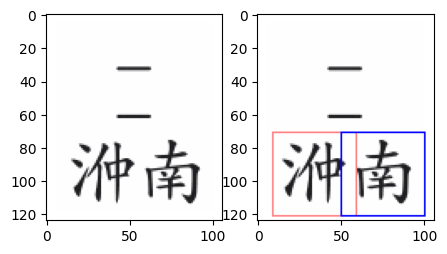

50 th jng has  ['hwang_u', 'lim']
total bbox:  2


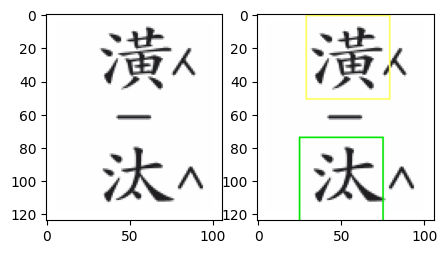

51 th jng has  ['hwang_u', 'nam']
total bbox:  2


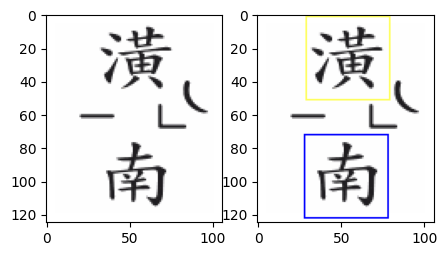

52 th jng has  ['lim']
total bbox:  1


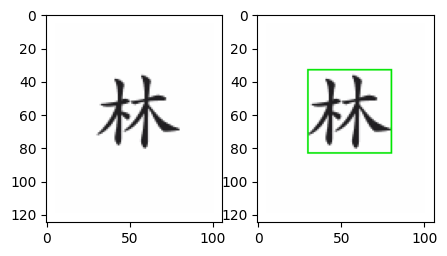

53 th jng has  []
total bbox:  0


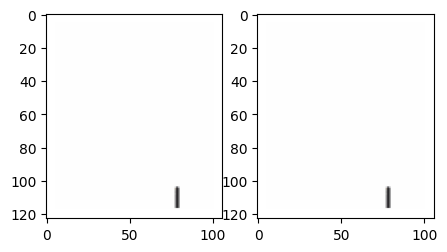

54 th jng has  []
total bbox:  0


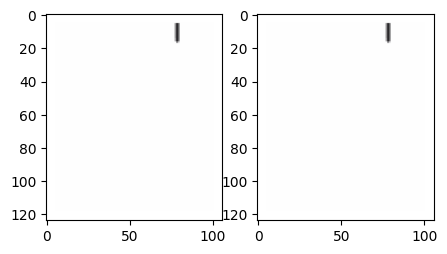

55 th jng has  []
total bbox:  0


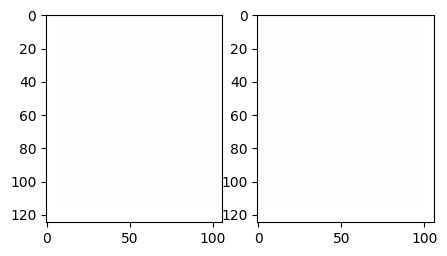

56 th jng has  []
total bbox:  0


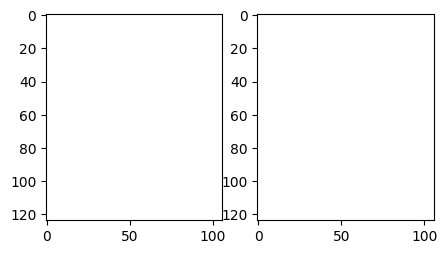

57 th jng has  []
total bbox:  0


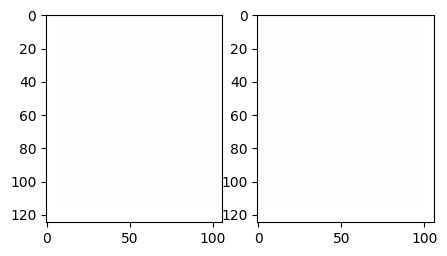

58 th jng has  []
total bbox:  0


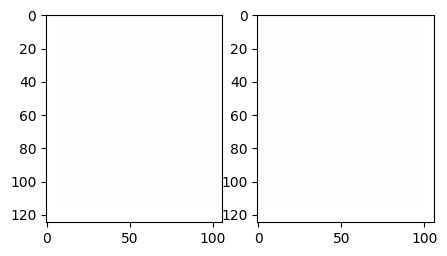

59 th jng has  []
total bbox:  0


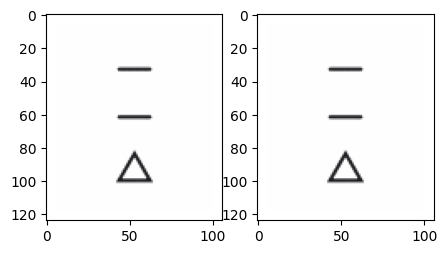

In [32]:
local_threshold = 0.5
local_ptrn_size = 50

for jng_idx in range(0, 60):# JNG_INDICES
  # load jeonggan img and remove borders
  jng_img = jng_matcher.remove_border_add_padding(target_jng_list[jng_idx][0])

  jng_bbox_list = []
  
  # match each pattern and merge overlapping bboxs
  for ptrn_key, ptrn_img in PTRN_IMG_DICT.items():
    xCords, yCords, match_result = jng_matcher.match(jng_img, ptrn_img, ptrn_size=local_ptrn_size, threshold=local_threshold)
    bboxs_w_confi = [(x, y, match_result[y][x]) for x, y in zip(xCords, yCords)]
    bboxs_merged = jng_matcher.merge_bboxs(bboxs_w_confi, ptrn_size=local_ptrn_size)
    
    bbox_total += len(bboxs_merged) # for debugging
    
    if len(bboxs_merged) > 0:
      jng_bbox_list += [bbox + (ptrn_key,) for bbox in bboxs_merged]
  
  # group bboxs on same character
  jng_bboxs = sorted(jng_bbox_list, key=lambda b: b[1])

  jng_bbox_groups = []
  index = 0
  
  while True:
    if index > len(jng_bboxs) - 1:
      break
    
    curr = jng_bboxs[index]

    # list of overlapping boxs and indices
    overlaps = jng_matcher.get_overlaps(jng_bboxs, curr, index, min_ratio=0.6)

    if len(overlaps) > 0:
      overlaps_box = [ tup[0] for tup in overlaps ]
      overlaps_box.append(curr)
      
      jng_bbox_groups.append( overlaps_box )
      
      # remove overlaps
      overlaps_idx = [ tup[1] for tup in overlaps ]
      overlaps_idx.sort(reverse=True)
      for overlap_idx in overlaps_idx:
        assert overlap_idx < len(jng_bboxs), f'index out of range: {overlap_idx} / {len(jng_bboxs) - 1}' 
        del jng_bboxs[overlap_idx]
        
    else:
      jng_bbox_groups.append( [curr] )

    index += 1
  
  # pick one bbox in each group by confidence score
  jng_bboxs_filtered =[]

  for group in jng_bbox_groups:
    jng_bboxs_filtered.append(max(group, key=lambda b: b[4]))
  
  # print result
  jng_img_cp = jng_img.copy()
  
  for box in jng_bboxs_filtered:
    tl_x, tl_y, br_x, br_y, confi, pname = box
    color = COLOR_DICT[pname]
    
    cv2.rectangle(jng_img_cp, (tl_x, tl_y), (br_x, br_y), color, 1)
  
  print(jng_idx, "th jng has ", [box[5] for box in jng_bboxs_filtered])
  print('total bbox: ', len(jng_bboxs_filtered))
  plt.figure(figsize=(5, 5))
  
  plt.subplot(1, 2, 1)
  plt.imshow(jng_img)

  plt.subplot(1, 2, 2)
  plt.imshow(jng_img_cp)
  
  plt.show()